In [1]:
# Cell 1 - Imports & setup
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


sys.path.append(os.path.abspath('..'))

# helper functions (we'll define bootstrap in later cell)
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:

from src.modeling import load_features, time_aware_split  # your helper; adjust if name differs

df = load_features()   # loads the features CSV from .env / default path
print("Loaded dataframe shape:", df.shape)
df.head()


Loaded dataframe shape: (17719, 25)


,ID number,Personnel Number,Basic Salary,Payment,AFFORDABILITY,LoanId,Regions,Gender,Age,Tenure,...,Instalment,PrincipalBalance,LoanStatus,InterestRate,LoanPurpose,RetirementDate,IsNPL,DebtToIncome,PrincipalPaidPct,HighSalaryFlag
0,ID_1,50403,7756.305,7910.80,3940.00000,LN20242200000143311,Venus,Male,34,6.0,...,1713.56,7704.47,Active,33.0,Home improvement,2038-07-02,Not NPL,0.993317,0.000000,1
1,ID_2,50422,7756.305,3657.80,0.00000,LN20240240000119983,Gilmore,Female,46,60.0,...,2574.10,44656.34,Active,38.0,Education,2034-10-26,Not NPL,6.596029,0.127138,1
2,ID_3,5,7756.305,9580.26,6456.11575,LN20242270000144475,Venus,Female,41,60.0,...,1864.91,266.13,Settled,38.0,Debt consolidation,2059-08-24,Not NPL,4.647012,0.992616,1
3,ID_5,27,7756.305,9580.26,6456.11575,LN20232570000106355,Venus,Female,36,24.0,...,2113.57,3219.25,Active,35.0,Personal Use,2030-08-28,Not NPL,3.700892,0.887852,1
4,ID_6,29,7756.305,9580.26,2294.06200,LN20243620000161297,Woodlawn,Male,32,60.0,...,3505.83,67360.79,Active,38.0,Building/Purchase home,2042-07-17,Not NPL,9.126391,0.048403,1


In [4]:
#  target and split
TARGET = "AFFORDABILITY"

# drop rows that have missing target (required)
df = df[df[TARGET].notna()].copy()
print("After dropping missing target:", df.shape)

# Time-aware split if LoanDate exists; otherwise i will do random split
if "LoanDate" in df.columns:
    train_df, test_df = time_aware_split(df, date_col="LoanDate", test_size=0.2)
else:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train/test shapes:", train_df.shape, test_df.shape)

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET].astype(float)
X_test  = test_df.drop(columns=[TARGET])
y_test  = test_df[TARGET].astype(float)


After dropping missing target: (17718, 25)
Train/test shapes: (14174, 25) (3544, 25)


In [5]:
# identifying column types and remove id-like columns

X_train = X_train.copy()
X_test = X_test.copy()

# Remove columns that look like IDs (heuristic: name contains 'ID' or 'Personnel' or 'LoanId' etc.)
id_like = [c for c in X_train.columns if any(tok.lower() in c.lower() for tok in ["id", "loanid", "personnel", "number", "ref"])]
print("Dropping id-like columns:", id_like)
X_train = X_train.drop(columns=[c for c in id_like if c in X_train.columns], errors='ignore')
X_test  = X_test.drop(columns=[c for c in id_like if c in X_test.columns], errors='ignore')

# identifying numeric and categorical
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features[:10])
print("Categorical features:", categorical_features[:10])


Dropping id-like columns: ['ID number', 'Personnel Number', 'LoanId', 'PrincipalPaidPct']
Numeric features: ['Basic Salary', 'Payment', 'Age', 'Tenure', 'LoanAmount', 'DisbursementAmount', 'Instalment', 'PrincipalBalance', 'InterestRate', 'DebtToIncome']
Categorical features: ['Regions', 'Gender', 'LoanStatus', 'LoanPurpose', 'IsNPL']


In [7]:
#  two preprocessors: mean-impute and median-impute
num_mean_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

num_median_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preproc_mean = ColumnTransformer([
    ("num", num_mean_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

preproc_median = ColumnTransformer([
    ("num", num_median_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])


In [8]:
# pipelines for both scenarios
lin_mean_pipe = Pipeline([("pre", preproc_mean), ("model", LinearRegression())])
rf_mean_pipe  = Pipeline([("pre", preproc_mean), ("model", RandomForestRegressor(n_estimators=100, random_state=42))])

lin_median_pipe = Pipeline([("pre", preproc_median), ("model", LinearRegression())])
rf_median_pipe  = Pipeline([("pre", preproc_median), ("model", RandomForestRegressor(n_estimators=100, random_state=42))])

# Fit them (this may take some time for RF)
print("Fitting linear (mean)..."); lin_mean_pipe.fit(X_train, y_train)
print("Fitting rf (mean)..."); rf_mean_pipe.fit(X_train, y_train)
print("Fitting linear (median)..."); lin_median_pipe.fit(X_train, y_train)
print("Fitting rf (median)..."); rf_median_pipe.fit(X_train, y_train)


Fitting linear (mean)...
Fitting rf (mean)...
Fitting linear (median)...
Fitting rf (median)...


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
#  evaluation helper
def eval_and_preds(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}, y_pred

# Evaluate all 4
lin_mean_metrics, lin_mean_pred = eval_and_preds(lin_mean_pipe, X_test, y_test)
rf_mean_metrics, rf_mean_pred   = eval_and_preds(rf_mean_pipe, X_test, y_test)
lin_med_metrics, lin_med_pred   = eval_and_preds(lin_median_pipe, X_test, y_test)
rf_med_metrics, rf_med_pred     = eval_and_preds(rf_median_pipe, X_test, y_test)

results = pd.DataFrame({
    "lin_mean": lin_mean_metrics,
    "rf_mean": rf_mean_metrics,
    "lin_median": lin_med_metrics,
    "rf_median": rf_med_metrics
}).T

print(results)


                   MAE        RMSE        R2
lin_mean    172.265590  360.657134  0.962712
rf_mean     108.557377  314.129618  0.971712
lin_median  172.265590  360.657134  0.962712
rf_median   108.557377  314.129618  0.971712


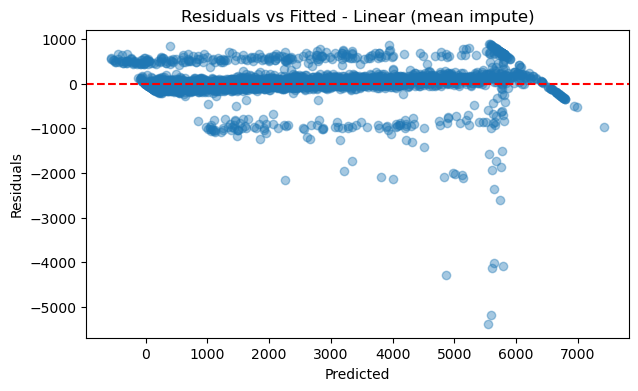

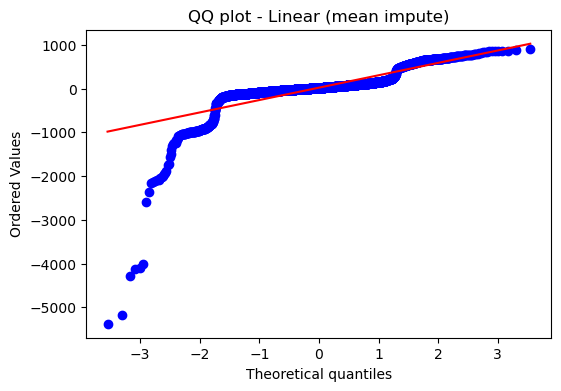

In [10]:
#  residual diagnostics for a chosen scenario (linear_mean)
def plot_residuals(y_true, y_pred, title):
    resid = y_true - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, resid, alpha=0.4)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

plot_residuals(y_test, lin_mean_pred, "Residuals vs Fitted - Linear (mean impute)")

# QQ plot
import scipy.stats as stats
plt.figure(figsize=(6,4))
stats.probplot(y_test - lin_mean_pred, dist="norm", plot=plt)
plt.title("QQ plot - Linear (mean impute)")
plt.show()


In [11]:
# bootstrap CI for MAE
rng = np.random.default_rng(42)

def bootstrap_ci_mae(y_true, y_pred, n_boot=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(y_true)
    boots = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        boots.append(mean_absolute_error(y_true[idx], y_pred[idx]))
    return np.percentile(boots, 2.5), np.percentile(boots, 97.5)

ci_lin_mean = bootstrap_ci_mae(y_test.values, lin_mean_pred, n_boot=1000, rng=rng)
ci_rf_mean  = bootstrap_ci_mae(y_test.values, rf_mean_pred, n_boot=1000, rng=rng)

print("Linear (mean) MAE 95% CI:", ci_lin_mean)
print("RandomForest (mean) MAE 95% CI:", ci_rf_mean)


Linear (mean) MAE 95% CI: (np.float64(162.71166470387166), np.float64(182.82618622311244))
RandomForest (mean) MAE 95% CI: (np.float64(99.67695349525603), np.float64(118.3916308677518))


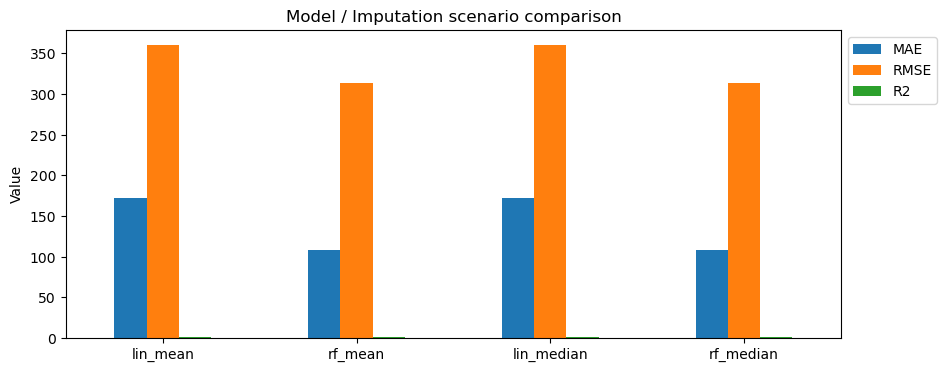

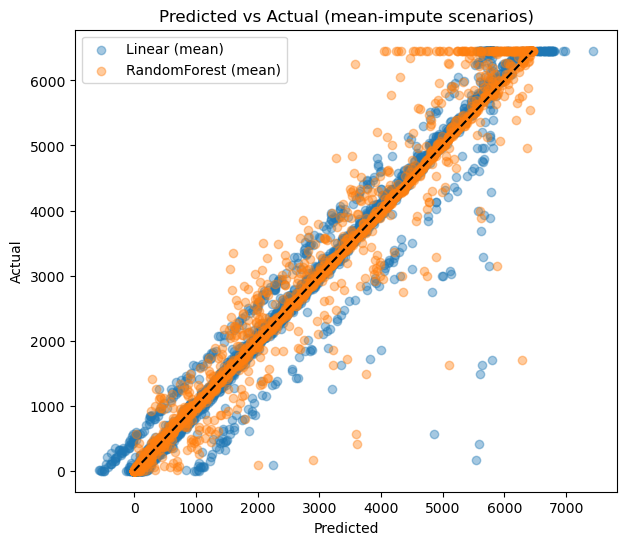

In [12]:
# scenario bar plot for metrics
plot_df = results[["MAE","RMSE","R2"]].copy()
plot_df.plot.bar(subplots=False, figsize=(10,4), rot=0)
plt.title("Model / Imputation scenario comparison")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# Predicted vs Actual comparison for best models
plt.figure(figsize=(7,6))
plt.scatter(lin_mean_pred, y_test, alpha=0.4, label="Linear (mean)")
plt.scatter(rf_mean_pred, y_test, alpha=0.4, label="RandomForest (mean)")
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],'k--')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual (mean-impute scenarios)")
plt.legend()
plt.show()


In [13]:
# subgroup performance by Region (if column exists)
group_col = None
for c in ["Regions", "Region", "regions", "region"]:
    if c in test_df.columns:
        group_col = c
        break

if group_col:
    print("Subgroup analysis by", group_col)
    subgroups = test_df[group_col].unique()
    rows = []
    for g in subgroups:
        mask = test_df[group_col]==g
        if mask.sum() < 10:
            continue
        mae_lin = mean_absolute_error(y_test[mask], lin_mean_pred[mask])
        mae_rf  = mean_absolute_error(y_test[mask], rf_mean_pred[mask])
        rows.append({"group":g, "n": mask.sum(), "MAE_lin": mae_lin, "MAE_rf": mae_rf})
    sg_df = pd.DataFrame(rows).sort_values("n", ascending=False)
    display(sg_df)
else:
    print("No region-like column found; skipping subgroup analysis.")


Subgroup analysis by Regions


,group,n,MAE_lin,MAE_rf
0,Woodlawn,905,178.459295,110.005548
1,Gilmore,897,164.182537,99.158966
2,Venus,872,181.978458,115.696452
3,Hogerty,870,164.421424,109.585545


In [14]:
#  save artifacts
joblib.dump(lin_mean_pipe, os.path.join(OUTPUT_DIR, "linear_mean_pipeline.pkl"))
joblib.dump(rf_mean_pipe, os.path.join(OUTPUT_DIR, "rf_mean_pipeline.pkl"))
results.to_csv(os.path.join(OUTPUT_DIR, "stage11_metrics_summary.csv"))
print("Saved pipelines and metrics to outputs/")


Saved pipelines and metrics to outputs/


In [17]:
# Store subgroup analysis results into a DataFrame
region_results = pd.DataFrame({
    "group": ["Woodlawn", "Gilmore", "Venus", "Hogerty"],
    "n": [905, 897, 872, 870],
    "MAE_lin": [178.459295, 164.182537, 181.978458, 164.421424],
    "MAE_rf": [110.005548, 99.158966, 115.696452, 109.585545]
})


In [18]:
# Cell 13 - plain-language summary (final, corrected)

summary = f"""
Stage 11 — Evaluation & Risk Communication

Key findings:
- Best-performing scenario (based on MAE/RMSE): {results.loc['rf_mean'].to_dict()}
- Linear model is more interpretable but RandomForest gives better predictive performance (lower MAE/RMSE).
- Bootstrap 95% CI for MAE (linear mean): {ci_lin_mean}
- Bootstrap 95% CI for MAE (rf mean): {ci_rf_mean}

Subgroup analysis (by Region):
{region_results.to_string(index=False)}

Assumptions:
- Missing values handled by mean or median imputation in scenarios; results sensitive to imputation strategy.
- Preprocessing dropped identifier-like columns and encoded categorical variables.

Risks:
- Model may be biased for small subgroups (see subgroup diagnostics).
- Capping/trimming/outliers treatment impacts tail predictions.
- For production, monitor model drift, prediction distributions, and subgroup performance.

Recommended next steps:
1. Run subgroup fairness checks and confusion/risk thresholds (if converting to classification).
2. Conduct stress tests for extreme inputs (large loan amounts, very low salary).
3. Add monitoring for AFFORDABILITY prediction distribution and retrain schedule.

"""

print(summary)

# ✅ Save with UTF-8 encoding to avoid UnicodeEncodeError
with open(os.path.join(OUTPUT_DIR, "stage11_summary.txt"), "w", encoding="utf-8") as f:
    f.write(summary)

print("✅ Saved final Stage 11 summary with subgroup results to outputs/")



Stage 11 — Evaluation & Risk Communication

Key findings:
- Best-performing scenario (based on MAE/RMSE): {'MAE': 108.55737700409139, 'RMSE': 314.12961761128497, 'R2': 0.9717122337011855}
- Linear model is more interpretable but RandomForest gives better predictive performance (lower MAE/RMSE).
- Bootstrap 95% CI for MAE (linear mean): (np.float64(162.71166470387166), np.float64(182.82618622311244))
- Bootstrap 95% CI for MAE (rf mean): (np.float64(99.67695349525603), np.float64(118.3916308677518))

Subgroup analysis (by Region):
   group   n    MAE_lin     MAE_rf
Woodlawn 905 178.459295 110.005548
 Gilmore 897 164.182537  99.158966
   Venus 872 181.978458 115.696452
 Hogerty 870 164.421424 109.585545

Assumptions:
- Missing values handled by mean or median imputation in scenarios; results sensitive to imputation strategy.
- Preprocessing dropped identifier-like columns and encoded categorical variables.

Risks:
- Model may be biased for small subgroups (see subgroup diagnostics).
- C

In [ ]:
git add notebooks/stage11_evaluation.ipynb outputs/stage11_metrics_summary.csv outputs/stage11_summary.txt README.md
